In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
import seaborn as sns

sns.set_theme(style="darkgrid")
%load_ext lab_black

## Importing data

Dev data: 1500 wav (mono, 8kHz) files (150 recordings for each digit)

`<ID>_<Label>.wav`

In [2]:
from pydub import AudioSegment


def trim(filename, target_dBFS=-20.0):
    def detect_leading_silence(sound, silence_threshold=-30.0, chunk_size=10):
        """
        sound is a pydub.AudioSegment
        silence_threshold in dB
        chunk_size in ms

        iterate over chunks until you find the first one with sound
        """
        trim_ms = 0  # ms

        assert chunk_size > 0  # to avoid infinite loop
        while sound[
            trim_ms : trim_ms + chunk_size
        ].dBFS < silence_threshold and trim_ms < len(sound):
            trim_ms += chunk_size

        return trim_ms

    # Normalize
    sound = AudioSegment.from_file(filename, format="wav")
    sound = sound.apply_gain(target_dBFS - sound.dBFS)

    # Trim
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    trimmed_sound = sound[start_trim : duration - end_trim]

    return trimmed_sound


def speed_change(sound, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    sound_with_altered_frame_rate = sound._spawn(
        sound.raw_data, overrides={"frame_rate": int(sound.frame_rate * speed)}
    )

    # convert the sound with altered frame rate to a standard frame rate
    # so that regular playback programs will work right. They often only
    # know how to play audio at standard frame rate (like 44.1k)
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)


def get_dev_X_y():
    import os

    DATASET_DIR = "../datasets/free-spoken-digit/dev/"
    filenames_and_ids = [
        (file, list(map(int, file.split(".")[0].split("_"))))
        for file in os.listdir(DATASET_DIR)
    ]
    X_audiofiles = [(trim(DATASET_DIR + f)) for f, _ in filenames_and_ids]
    y = [ids[1] for _, ids in filenames_and_ids]
    return X_audiofiles, np.array(y)


def process_X(X_audiofiles):
    N_SAMPLES = 1500

    X_audiofiles = [
        speed_change(audio_file, (len(audio_file.get_array_of_samples()) / N_SAMPLES))
        for audio_file in X_audiofiles
    ]

    X = [np.array(audio_file.get_array_of_samples()) for audio_file in X_audiofiles]
    X = [np.append(x, [0] * (N_SAMPLES - len(x))) for x in X]
    assert all([track.shape[0] == N_SAMPLES for track in X])

    return X


X_audiofiles, y = get_dev_X_y()
X = process_X(X_audiofiles)

In [3]:
X_audiofiles[0]

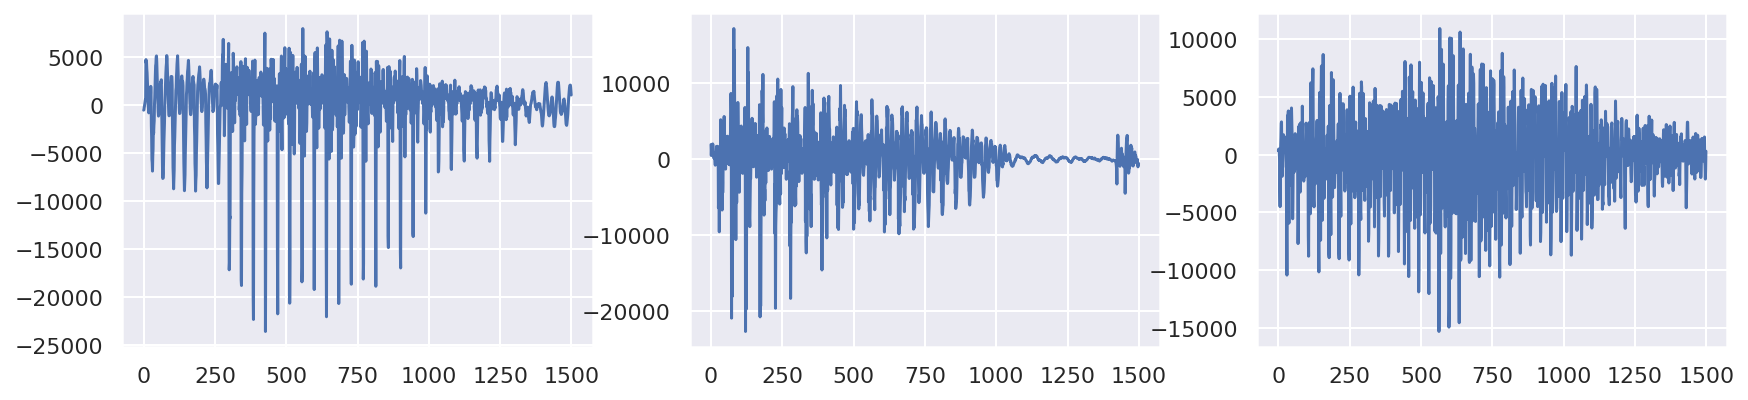

In [4]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
plt.tight_layout()
for ax in axes.ravel():
    ax.plot(X[np.random.randint(0, len(X))])

In [5]:
from librosa.feature import mfcc


def apply_MFCC(X):
    return np.array([mfcc(x.astype(float), sr=8_000, n_fft=512).reshape(-1) for x in X])


X = apply_MFCC(X)

In [6]:
X.shape

(1500, 60)

In [7]:
y.shape

(1500,)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.88

## Eval set

Quindi posso cambiare, `process_X`, `apply_MFCC`, e `clf.predict(X)` e in un colpo rifaccio la submission.

In [10]:
def get_eval_X():
    import os

    DATASET_DIR = "../datasets/free-spoken-digit/eval/"
    X_audiofiles = [
        trim(DATASET_DIR + file)
        for file in sorted(
            os.listdir("../datasets/free-spoken-digit/eval/"),
            key=lambda f: int(f.split(".")[0]),
        )
    ]
    return X_audiofiles


X_audiofiles = get_eval_X()
X = process_X(X_audiofiles)
X = apply_MFCC(X)

print(pd.DataFrame(clf.predict(X), columns=["Predicted"]).to_csv())

,Predicted
0,2
1,9
2,2
3,9
4,8
5,9
6,6
7,9
8,5
9,8
10,3
11,4
12,1
13,0
14,7
15,6
16,4
17,6
18,4
19,0
20,3
21,7
22,4
23,1
24,2
25,7
26,7
27,4
28,1
29,7
30,6
31,1
32,5
33,8
34,9
35,0
36,1
37,0
38,1
39,0
40,7
41,3
42,7
43,6
44,8
45,0
46,0
47,7
48,0
49,6
50,6
51,0
52,2
53,0
54,0
55,5
56,0
57,7
58,7
59,2
60,3
61,7
62,8
63,3
64,7
65,5
66,9
67,0
68,1
69,2
70,2
71,6
72,5
73,2
74,4
75,9
76,8
77,1
78,8
79,8
80,7
81,7
82,1
83,6
84,1
85,4
86,0
87,1
88,1
89,2
90,4
91,3
92,7
93,3
94,7
95,2
96,7
97,4
98,1
99,1
100,9
101,4
102,7
103,1
104,8
105,2
106,3
107,1
108,6
109,5
110,3
111,5
112,3
113,1
114,8
115,1
116,4
117,9
118,1
119,6
120,4
121,9
122,8
123,8
124,4
125,3
126,8
127,9
128,5
129,2
130,7
131,2
132,3
133,9
134,3
135,8
136,3
137,0
138,5
139,2
140,2
141,8
142,1
143,4
144,3
145,2
146,9
147,7
148,6
149,0
150,0
151,6
152,8
153,9
154,7
155,7
156,5
157,5
158,7
159,9
160,5
161,4
162,8
163,9
164,7
165,7
166,2
167,0
168,5
169,1
170,2
171,9
172,5
173,0
174,2
175,8
176,0
177,2
178,8
179,4
180,9
181,0
182,5
1